# annotation of the twin batches separately

In [1]:
import cytovi
import scanpy as sc
import anndata as ad
import readfcs
import seaborn as sns
import os

Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


# batch 1

In [28]:
# read fcs files and add md
data_dir = '../data/raw/CyTOF/twins/surface/batch1'
files =  os.listdir(data_dir)
fcs_files = [files[i] for i in [4, 6]]

adata_list = []
sample_num = 0

for fcs_file in fcs_files:
    if fcs_file.endswith('.fcs'):
        fcs_path = os.path.join(data_dir, fcs_file)
        adata = readfcs.read(fcs_path)

        # rename var_names
        marker_names = []
        channels = adata.var['marker'].str.split('_')
        for row in channels:
            marker_names.append(row[1])
        adata.var['marker'] = marker_names
        adata.var_names = marker_names

        # add md
        adata.obs['filename'] = fcs_file
        adata.obs['sample_id'] = sample_num

        adata.layers['raw'] = adata.X.copy()
    
        sample_num += 1
        adata_list.append(adata)

adata = ad.concat(adata_list, join='outer', label='sample_id')
adata.obs_names_make_unique()  

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [29]:
# preprocess
cytovi.pp.arcsinh(adata, global_scaling_factor = 10) 
cytovi.pp.scale(adata)

In [30]:
# run umap
adata.X = adata.layers['scaled']
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [31]:
sc.tl.leiden(adata, key_added="leiden_PCA", resolution = 0.3)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


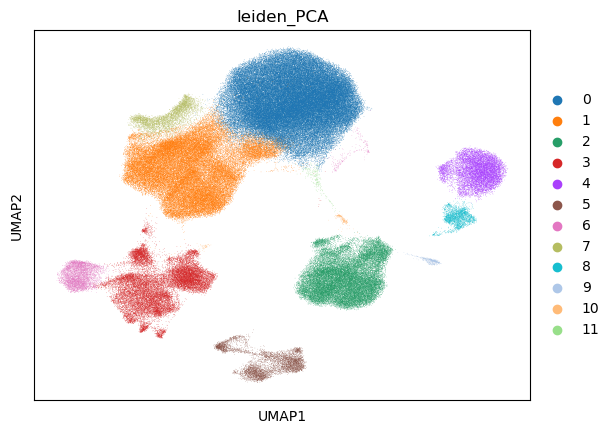

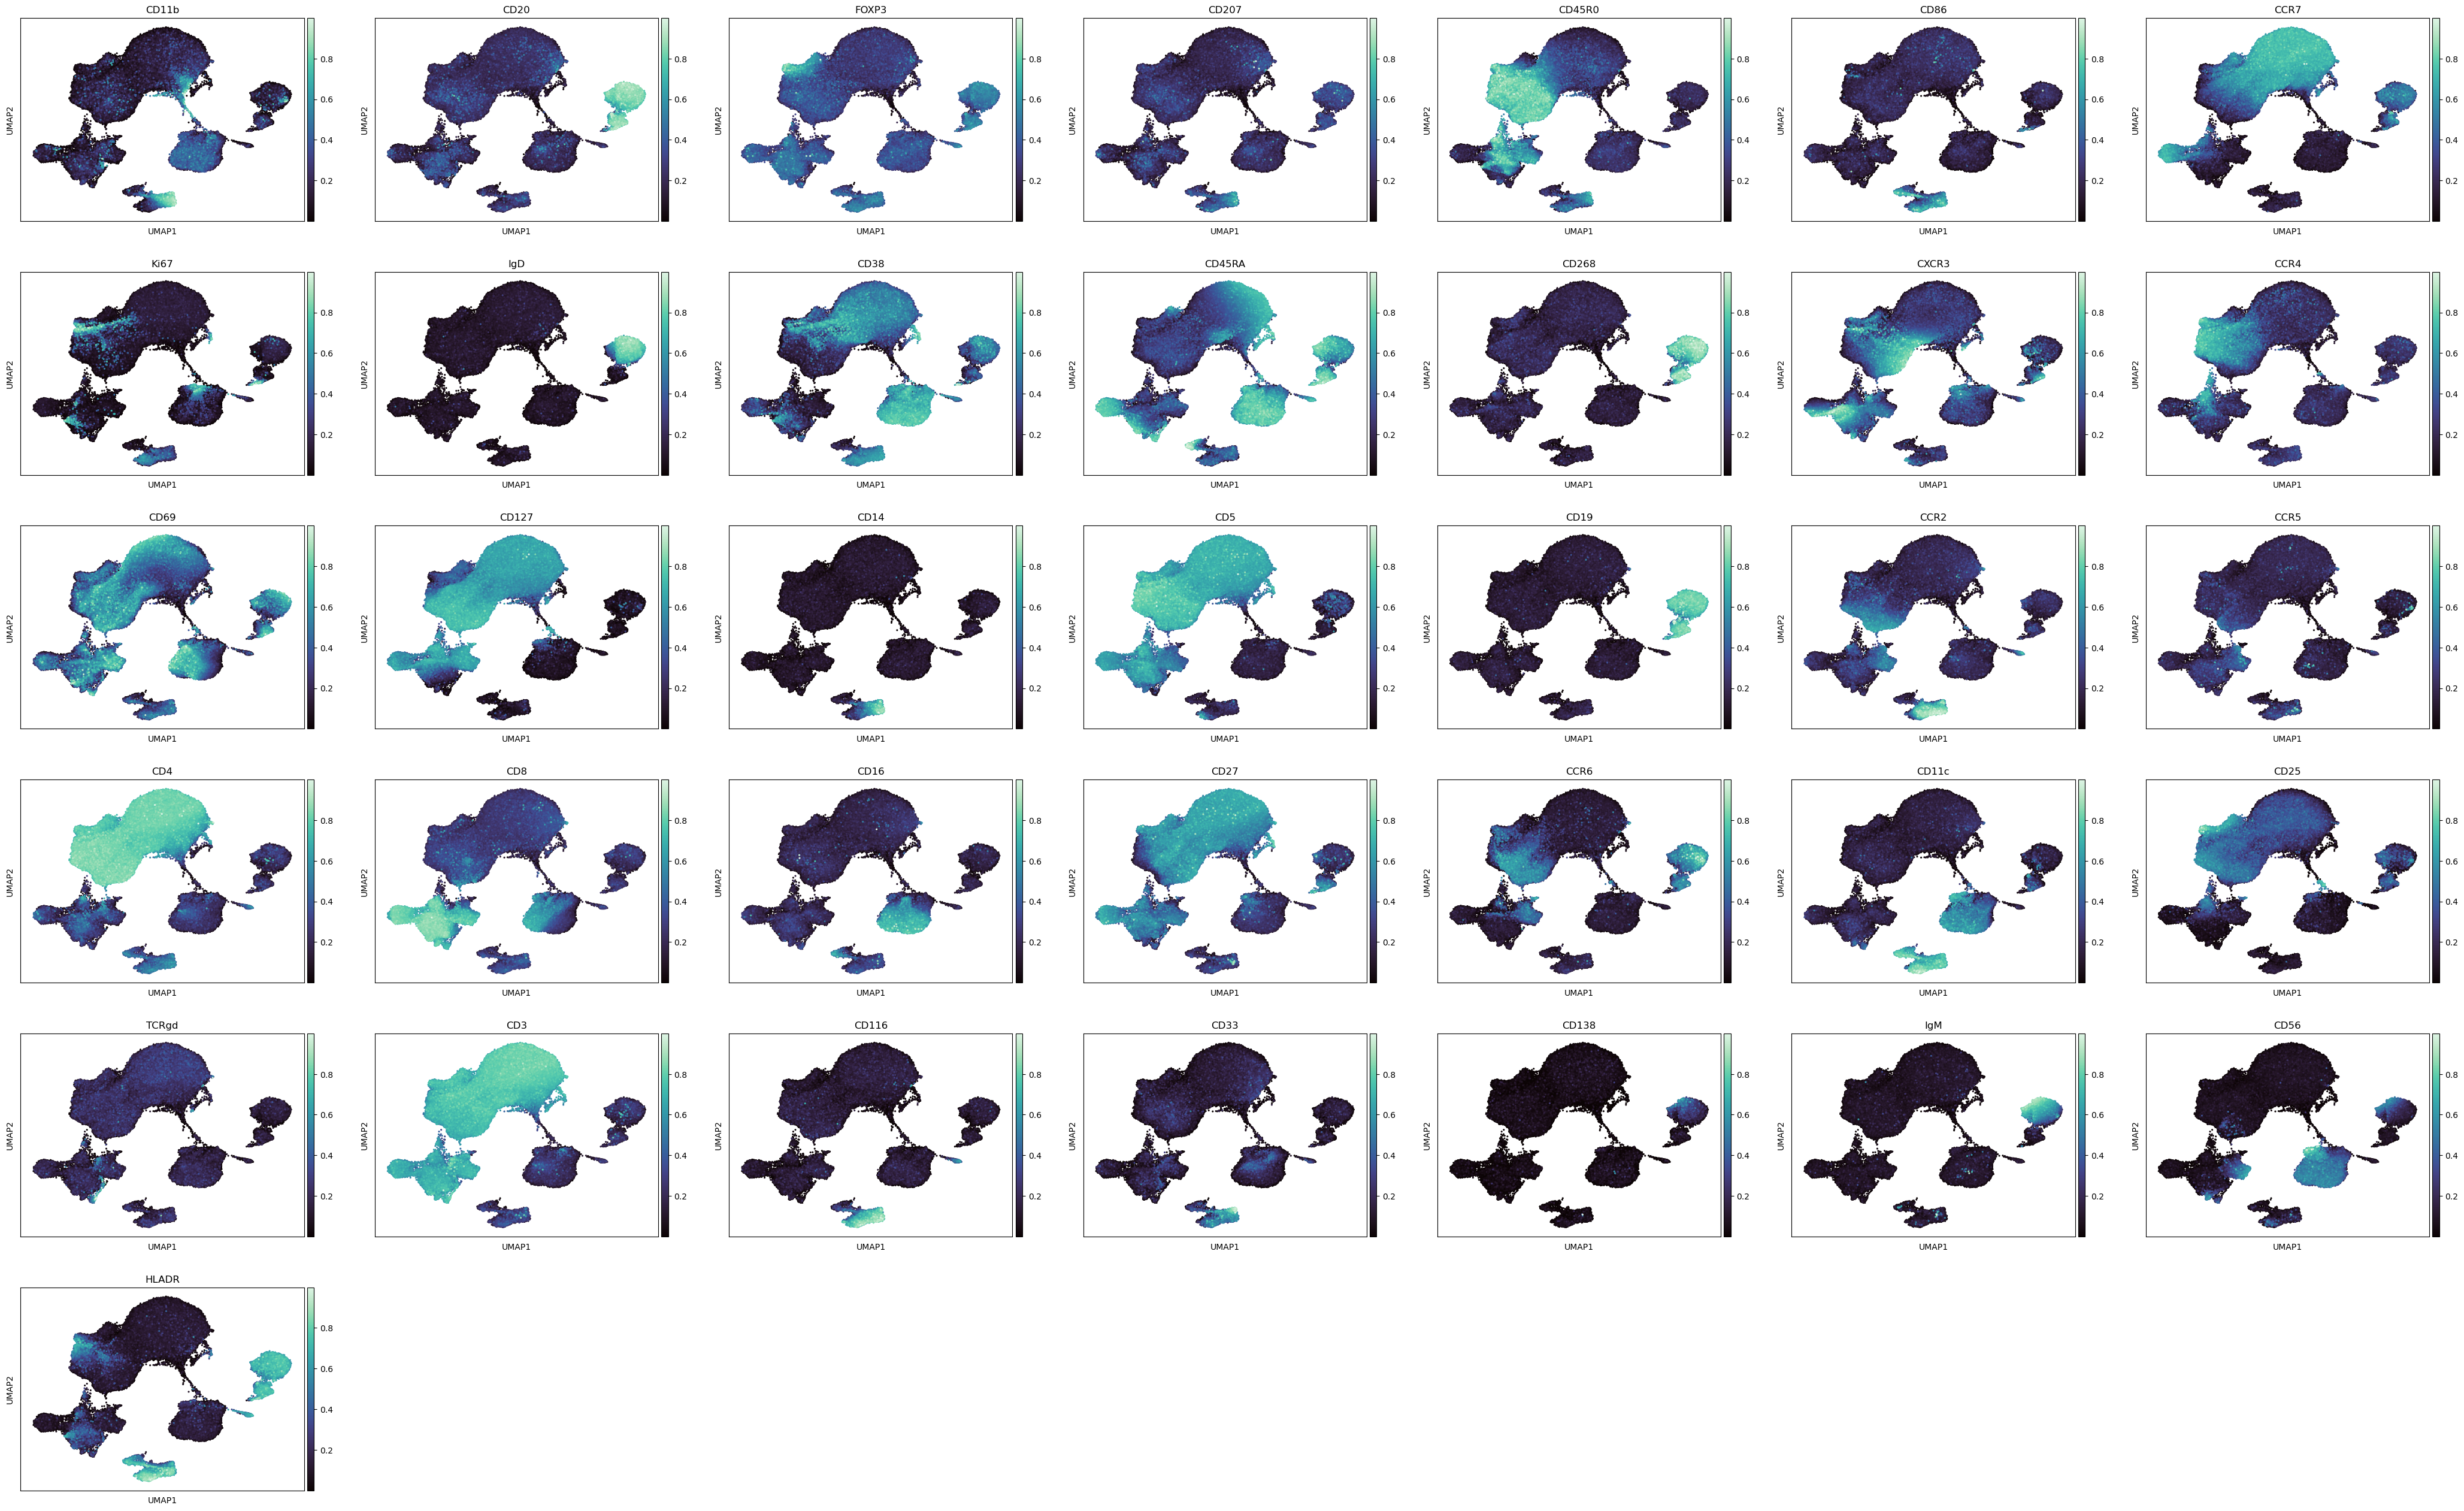

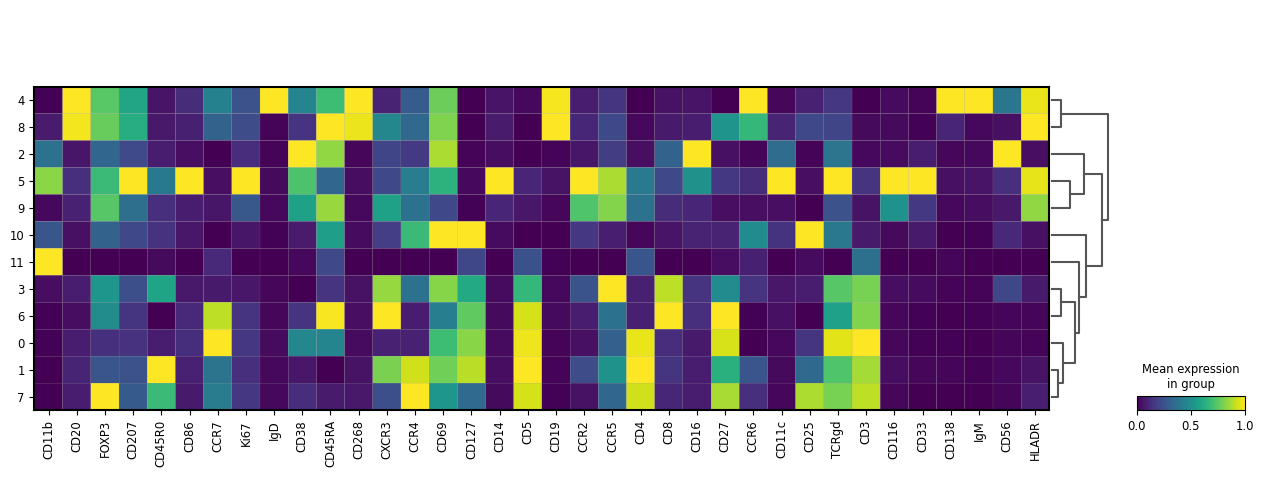

In [32]:
# plotting
sc.pl.umap(adata, color = 'leiden_PCA')
sc.pl.umap(adata, color = list(adata.var_names), cmap= sns.color_palette("mako", as_cmap=True), s = 20, use_raw = False, layer = 'scaled', ncols= 7)
sc.pl.matrixplot(adata, var_names=list(adata.var_names), dendrogram=True, groupby='leiden_PCA', use_raw = False, layer = 'scaled', standard_scale='var')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


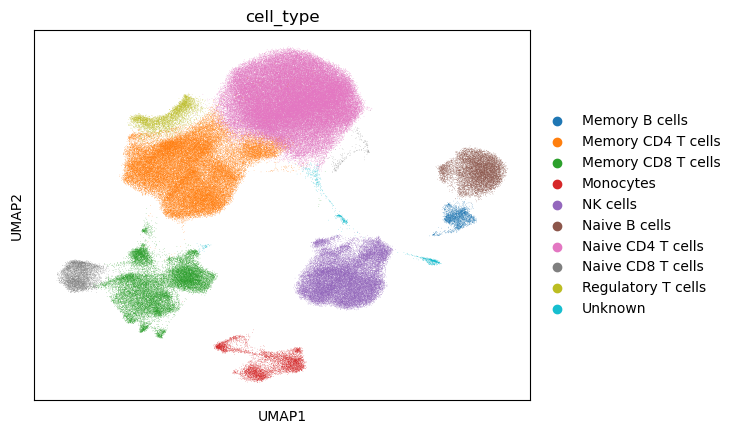

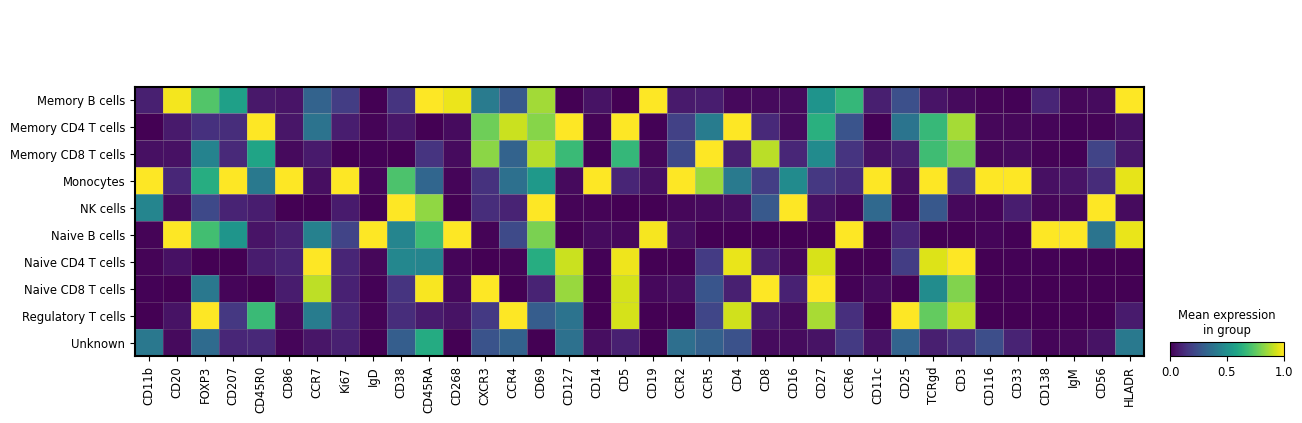

In [33]:
# annotate
ann_dict = {'0': 'Naive CD4 T cells',
            '1': 'Memory CD4 T cells',
            '2': 'NK cells',
            '3': 'Memory CD8 T cells',
            '4': 'Naive B cells',
            '5': 'Monocytes',
            '6': 'Naive CD8 T cells',
            '7': 'Regulatory T cells',
            '8': 'Memory B cells',
            '9': 'Unknown',
            '10': 'Unknown',
            '11': 'Unknown'
    }

adata.obs['cell_type'] = adata.obs['leiden_PCA'].map(ann_dict).astype('category')

sc.pl.umap(adata, color = 'cell_type')
sc.pl.matrixplot(adata, var_names=list(adata.var_names), groupby='cell_type', use_raw = False, layer = 'scaled', standard_scale='var')

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


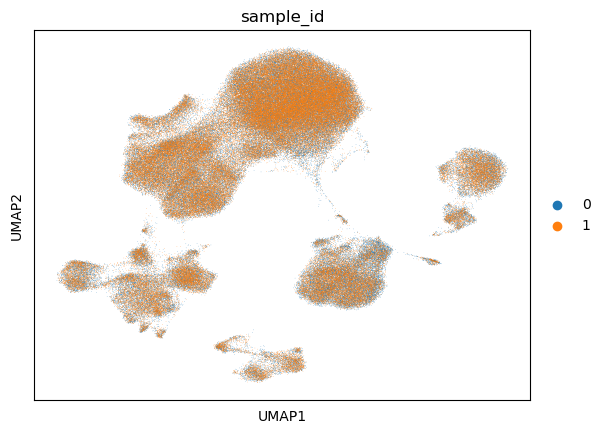

In [36]:
sc.pl.umap(adata, color = 'sample_id')

In [38]:
adata_batch1_ann = adata.copy()

In [49]:
# save h5ad files
# delete the scaler params to circumvent saving issues
del adata_batch1_ann.uns['scaler_params']

adata_batch1_ann.write('../data/raw/CyTOF/twins/surface/batch1/annotated/2024-01-16_norm_samples_batch1_ann.h5ad')